- Getting the info of all the vehicles in the env 
  - Vehicles include ego vehicle, env spawned vehicle, mannually spawned vehicle
  - Info include their positons, current speed ...

In [ ]:
from metadrive.envs import MetaDriveEnv
from metadrive.policy.idm_policy import IDMPolicy
from metadrive.manager import BaseManager
from metadrive.component.vehicle.vehicle_type import DefaultVehicle
from IPython.display import clear_output, Image

class ExampleManager(BaseManager):
    def __init__(self):
        super(ExampleManager, self).__init__()
        self.generated_v = None
        self.generate_ts = 1
        self.recycle_ts = 100
        
    def before_step(self):
        if self.generated_v:
            self.generated_v.before_step([0, 1]) # set action for v
            self.generated_v2.before_step([0, 1]) # set action for v2
        
    def after_step(self):
        if self.episode_step == self.generate_ts:
            # these two are our mannually spawned vehicles
            self.generated_v = self.spawn_object(DefaultVehicle, 
                                  vehicle_config=(dict(max_speed_km_h=20)), 
                                  position=(20,4), 
                                  heading=0,
                                  )
            self.generated_v2 = self.spawn_object(DefaultVehicle, 
                                  vehicle_config=dict(dict(max_speed_km_h=20)), 
                                  position=(20, 0), 
                                  heading=0)
        elif self.episode_step == self.recycle_ts:
            self.clear_objects([self.generated_v.id])
            self.generated_v = None
        elif self.generated_v:
            self.generated_v.after_step()

class ExampleEnv(MetaDriveEnv):

    def setup_engine(self):
        super(ExampleEnv, self).setup_engine()
        self.engine.register_manager("exp_mgr", ExampleManager())

In [6]:
from metadrive.component.map.base_map import BaseMap
from metadrive.component.map.pg_map import MapGenerateMethod
from metadrive.component.static_object.traffic_object import TrafficCone

map_config={
            BaseMap.GENERATE_TYPE: MapGenerateMethod.BIG_BLOCK_SEQUENCE, 
            BaseMap.GENERATE_CONFIG: "SS",  
            BaseMap.LANE_WIDTH: 3.5,
            BaseMap.LANE_NUM: 2,
            }

env = ExampleEnv(dict(
                      map_config=map_config,
                    #   agent_policy=IDMPolicy,
                      traffic_density=0.2, # set traffic density larger than 0 to have vehicles spawned by env automatically
                      accident_prob=0,
                      speed_reward = 1,))

try:
    env.reset()
    all_vehicles = env.engine.agents

    print(env.config["success_reward"],env.config["speed_reward"])

    for step in range(300):
        o,r,tm,tc,i = env.step([0, 1]) 
        if step == 1:
            # Get ego vehicle's info
            print("Get ego vehicle's info")
            print(f"Step: {step}")
            print(f"ego vehicle id: {env.agent.id}")
            print(f"ego vehicle position: {env.agent.position}")
            print(f"ego vehicle speed: {env.agent.speed_km_h} km/h")
            print("-" * 30)
            # Another way to get ego vehicle's info (suitable for multi-agent env)
            print("Another way to get ego vehicle's info (suitable for multi-agent env)")
            for agent_id, vehicle in all_vehicles.items(): 
                print(f"Vehicle ID: {agent_id}")
                print(f"Position: {vehicle.position}")
                print(f"Speed: {vehicle.speed_km_h} km/h")
                print("-" * 30)
            # Get env spawned vehicles' info
            print("Get env spawned vehicles' info")
            for vehicle_id, vehicle in env.engine.traffic_manager.spawned_objects.items():
                print(f"Vehicle ID: {vehicle_id}")
                print(f"Vehicle Data: {vehicle}")
                print(f"Position: {vehicle.position}")
                print(f"Speed: {vehicle.speed_km_h} km/h")
                print(f"Type: {type(vehicle)}")
                print("-" * 30)
            # Get manual spawned vehicles' info
            print("Get manual spawned vehicles' info")
            print(env.engine.managers["exp_mgr"].generated_v.position)
            print(env.engine.managers["exp_mgr"].generated_v.max_speed_km_h)
        env.render(mode="topdown", 
                   window=False,
                   screen_size=(800, 600),
                   camera_position=(70, 10),
                   screen_record=True,
                   text={"manually spawned vehicle 1": env.engine.managers["exp_mgr"].generated_v.position, # put the info on the screen 
                        "manually spawned vehicle 2": env.engine.managers["exp_mgr"].generated_v2.position,
                         "Timestep": env.episode_step})
        if tm:
            break
    env.top_down_renderer.generate_gif()
finally:
    env.close()


[INFO] Environment: ExampleEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


self.mode in engin_core none
10.0 1
Get ego vehicle's info
Step: 1
ego vehicle id: fa2d596f-090d-46bc-a36f-85f19970ff84
ego vehicle position: (5.039768218994141, 3.5)
ego vehicle speed: 1.9884138107299898 km/h
------------------------------
Another way to get ego vehicle's info (suitable for multi-agent env)
Vehicle ID: default_agent
Position: (5.039768218994141, 3.5)
Speed: 1.9884138107299898 km/h
------------------------------
Get env spawned vehicles' info
Vehicle ID: 4f25a7c9-7e91-44a7-bfe2-7924dcc80f43
Vehicle Data: MVehicle, ID:4f25a7c9-7e91-44a7-bfe2-7924dcc80f43
Position: (109.99984741210938, 0.0)
Speed: 0.052538171410564966 km/h
Type: <class 'metadrive.component.vehicle.vehicle_type.MVehicle'>
------------------------------
Vehicle ID: 314d6eaa-e0da-4811-8f11-1727aff0844f
Vehicle Data: SVehicle, ID:314d6eaa-e0da-4811-8f11-1727aff0844f
Position: (60.0, 3.5)
Speed: 0.0 km/h
Type: <class 'metadrive.component.vehicle.vehicle_type.SVehicle'>
------------------------------
Vehicle I

[INFO] Episode ended! Scenario Index: 0 Reason: crash vehicle 


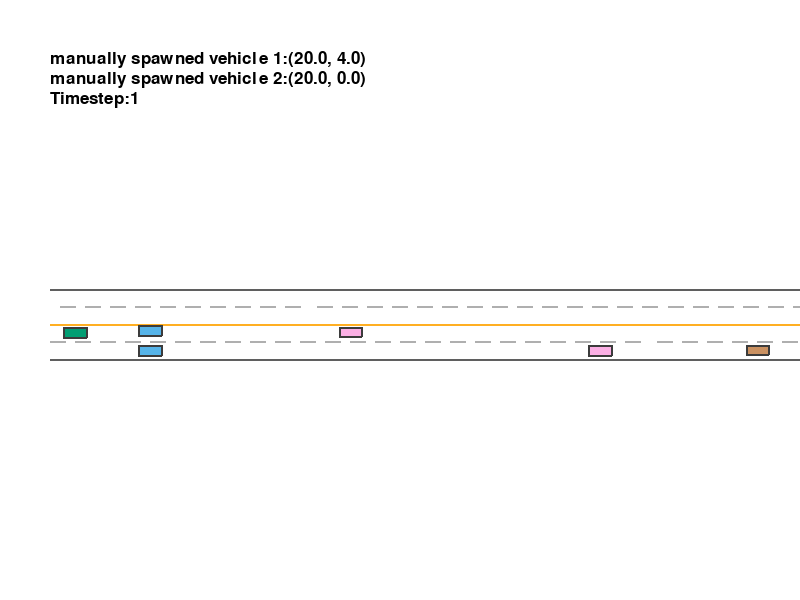

In [7]:
Image(open("demo.gif", 'rb').read())